# **KELOMPOK 6: Prediksi Harga dan Status Penjualan Mobil Bekas Menggunakan AI**
##### **Anggota: Greflyn Felinstya - Reyza Syaifullah - Evanly Bawalo**

###### Dataset: USED CAR SALES IN AMERICA (Kaggle)_10000 Data

# *Libraries & Datasey*

In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, ColorBar, BasicTicker, PrintfTickFormatter, Div
from bokeh.transform import factor_cmap
from bokeh.palettes import Blues256
from bokeh.layouts import column
from bokeh.transform import transform
from bokeh.io import output_notebook, show
import seaborn as sns
import matplotlib.pyplot as plt

output_notebook()

Loading BokehJS ...

In [15]:
df = pd.read_csv("used_car_sales.csv")
df['Car Sale Status'] = df['Car Sale Status'].str.strip().str.lower()
df = df[df['Car Sale Status'].isin(['sold', 'un sold'])]


Exploratory Data Analysis (EDA):

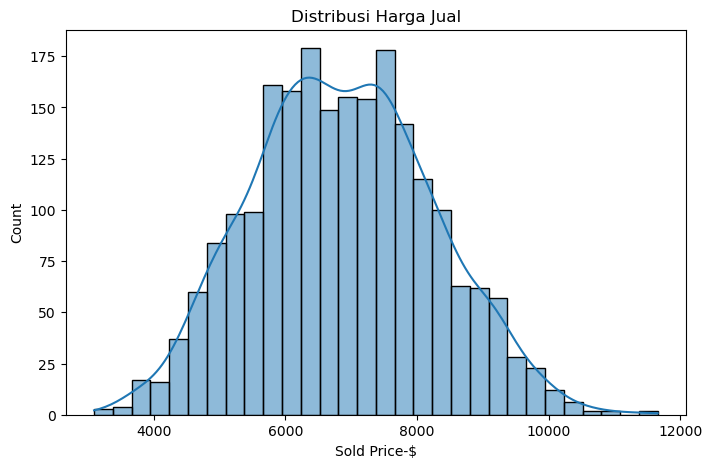

In [16]:
sold_cars = df[df['Car Sale Status'] == 'sold']
plt.figure(figsize=(8, 5))
sns.histplot(sold_cars['Sold Price-$'], bins=30, kde=True)
plt.title("Distribusi Harga Jual")
plt.show()


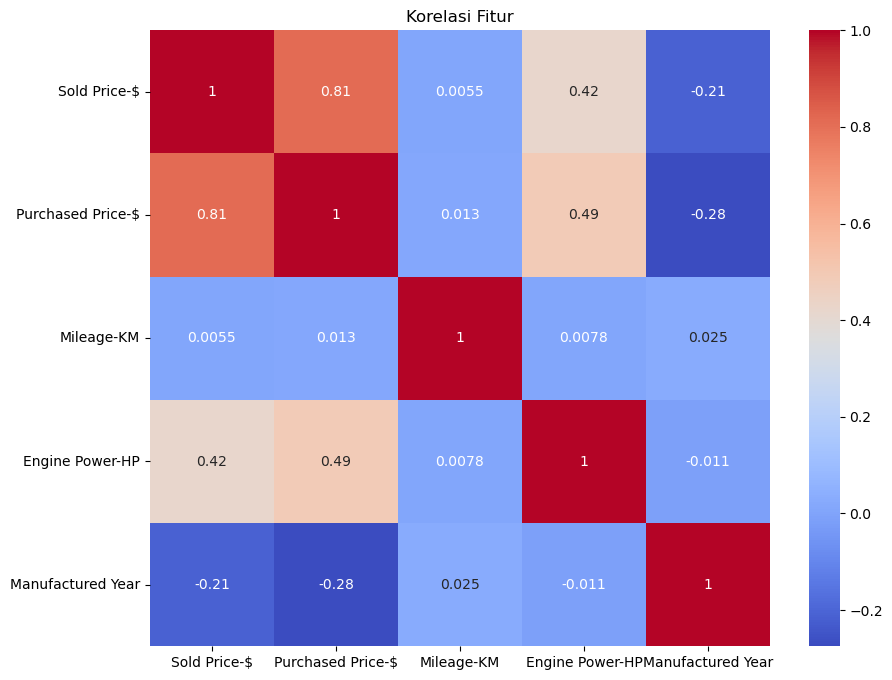

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(sold_cars[['Sold Price-$', 'Purchased Price-$', 'Mileage-KM', 'Engine Power-HP', 'Manufactured Year']].corr(), annot=True, cmap="coolwarm")
plt.title("Korelasi Fitur")
plt.show()

#### **1. Prediksi Harga Jual**

In [18]:
reg_features = ['Mileage-KM', 'Engine Power-HP', 'Manufactured Year', 'Purchased Price-$']
sold_cars = sold_cars.dropna(subset=reg_features + ['Sold Price-$'])
X_reg = sold_cars[reg_features]
y_reg = sold_cars['Sold Price-$']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

reg_model = LinearRegression()
reg_model.fit(X_train_reg, y_train_reg)

y_pred_reg = reg_model.predict(X_test_reg)

mae = mean_absolute_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"Regression - MAE: ${mae:.2f}")
print(f"Regression - RMSE: ${rmse:.2f}")
print(f"Regression - R² Score: {r2:.3f}")

source_reg = ColumnDataSource(data=dict(
    actual=y_test_reg,
    predicted=y_pred_reg,
    mileage=X_test_reg['Mileage-KM']
))

p_reg = figure(title="Prediksi Harga Jual Mobil (Regression)", 
               x_axis_label="Harga Sebenarnya ($)", 
               y_axis_label="Harga Prediksi ($)",
               tools="pan,wheel_zoom,hover,reset", width=700, height=400)

p_reg.circle("actual", "predicted", size=6, source=source_reg, color="blue", alpha=0.5)

hover_reg = p_reg.select_one(HoverTool)
hover_reg.tooltips = [
    ("Harga Sebenarnya", "@actual{$0,0}"),
    ("Harga Prediksi", "@predicted{$0,0}"),
    ("Mileage-KM", "@mileage{0,0}")
]

show(p_reg)


Regression - MAE: $686.02
Regression - RMSE: $799.00
Regression - R² Score: 0.658


#### **2. Prediksi Status Terjual atau Tidak**

In [19]:
class_features = ['Mileage-KM', 'Engine Power-HP', 'Manufactured Year', 'Purchased Price-$']
df_class = df.dropna(subset=class_features)
df_class['Car Sale Status'] = df_class['Car Sale Status'].map({'un sold': 0, 'sold': 1})

X_class = df_class[class_features]
y_class = df_class['Car Sale Status']

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42)

class_model = RandomForestClassifier(n_estimators=100, random_state=42)
class_model.fit(X_train_class, y_train_class)

y_pred_class = class_model.predict(X_test_class)

report = classification_report(y_test_class, y_pred_class, target_names=['0', '1'])
report_div = Div(text=f"<pre>{report}</pre>", width=500, height=200)

df_result = X_test_class.copy()
df_result['Actual'] = y_test_class.values
df_result['Predicted'] = y_pred_class

cm_counts = df_result.groupby(['Actual', 'Predicted']).size().reset_index(name='Jumlah')
cm_means = df_result.groupby(['Actual', 'Predicted'])[class_features].mean().reset_index()
cm_full_df = pd.merge(cm_counts, cm_means, on=['Actual', 'Predicted'], how='left')
cm_full_df['Actual'] = cm_full_df['Actual'].astype(str)
cm_full_df['Predicted'] = cm_full_df['Predicted'].astype(str)

source_matrix = ColumnDataSource(cm_full_df)

mapper = LinearColorMapper(palette=Blues256, low=cm_full_df.Jumlah.max(), high=cm_full_df.Jumlah.min())

p_matrix = figure(title="Heatmap Confusion Matrix",
                  x_range=['0', '1'], y_range=['1', '0'],
                  x_axis_label='Predicted', y_axis_label='Actual',
                  toolbar_location=None, tools="", width=500, height=400)

p_matrix.rect(x='Predicted', y='Actual', width=1, height=1, source=source_matrix,
              fill_color={'field': 'Jumlah', 'transform': mapper}, line_color='white')

hover_matrix = HoverTool(tooltips=[
    ("Predicted", "@Predicted"),
    ("Actual", "@Actual"),
    ("Jumlah", "@Jumlah"),
    ("AVG Mileage-KM", "@{Mileage-KM}{0.0}"),
    ("AVG Engine Power-HP", "@{Engine Power-HP}{0.0}"),
    ("AVG Manufactured Year", "@{Manufactured Year}{0.0}"),
    ("AVG Purchased Price-$", "@{Purchased Price-$}{0.0}")
])
p_matrix.add_tools(hover_matrix)
p_matrix.xgrid.grid_line_color = None
p_matrix.ygrid.grid_line_color = None
p_matrix.axis.major_label_text_font_size = "12pt"
p_matrix.title.text_font_size = '14pt'

color_bar = ColorBar(color_mapper=mapper, major_label_text_font_size="10pt",
                     label_standoff=8, border_line_color="black", location=(0,0))

p_matrix.add_layout(color_bar, 'right')
layout = column(p_matrix, report_div)
show(layout)

#### **3. Pengelompokkan Mobil**

In [20]:
cluster_features = ['Purchased Price-$', 'Mileage-KM', 'Manufactured Year']
df_cluster = df.dropna(subset=cluster_features)
X_cluster = df_cluster[cluster_features]

kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster['Cluster'] = kmeans.fit_predict(X_cluster)

source_cluster = ColumnDataSource(data=dict(
    price=df_cluster['Purchased Price-$'],
    mileage=df_cluster['Mileage-KM'],
    cluster=df_cluster['Cluster'].astype(str)
))

p_cluster = figure(title="Clustering Mobil Berdasarkan Harga, Mileage, Tahun", 
                   x_axis_label="Purchased Price-$", 
                   y_axis_label="Mileage-KM",
                   tools="pan,wheel_zoom,hover,reset", width=700, height=400)

colors = ["red", "green", "blue"]
p_cluster.circle("price", "mileage", size=7, source=source_cluster, 
                 color=factor_cmap("cluster", palette=colors, factors=["0", "1", "2"]), alpha=0.6)

hover_cluster = p_cluster.select_one(HoverTool)
hover_cluster.tooltips = [
    ("Purchased Price", "@price{$0,0}"),
    ("Mileage-KM", "@mileage{0,0}"),
    ("Cluster", "@cluster")
]

show(p_cluster)

#### **Kesimpulan**

Sistem AI yang kami buat mampu memproses data mobil bekas untuk membantu analisis harga jual, status penjualan, dan segmentasi pasar.

Dengan pengembangan lebih lanjut, model ini berpotensi untuk digunakan dalam bisnis jual-beli mobil bekas.